### 1. Import

In [3]:
import sys
print(sys.executable)

C:\Users\Admin\miniconda3\envs\robot\python.exe


In [4]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from agent import Agent, img_stack
import time
from collections import deque
import matplotlib
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

seed = 0 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

action_repeat = 10
env = gym.make('CarRacing-v0', verbose=0)
state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)

device:  cuda
env.action_space.shape:  (3,)
reward_threshold 900


### 2. Image Preprocessing

frame.shape:  (96, 96, 3)


Exception ignored in: <function Viewer.__del__ at 0x00000229647081F0>
Traceback (most recent call last):
  File "C:\Users\Admin\miniconda3\envs\robot\lib\site-packages\gym\envs\classic_control\rendering.py", line 162, in __del__
    self.close()
  File "C:\Users\Admin\miniconda3\envs\robot\lib\site-packages\gym\envs\classic_control\rendering.py", line 81, in close
    self.window.close()
  File "C:\Users\Admin\miniconda3\envs\robot\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\Admin\miniconda3\envs\robot\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\Admin\miniconda3\envs\robot\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x00000229646A8450; to 'Win32Window' at 0x00000229642D77C0>


img.shape:  (96, 96)


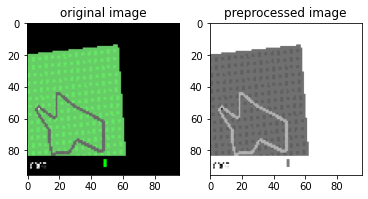

In [5]:
# show what a preprocessed image looks like
frame, _, _, _ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

### 2. Class  Wrapper

In [6]:
class Wrapper():
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, env):
        self.env = env  

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = env.reset()
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(action_repeat):
            img_rgb, reward, die, _ = env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack
        return np.array(self.stack), total_reward, done, die


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [7]:
def save(agent, directory, filename, suffix):
    torch.save(agent.net.state_dict(), '%s/%s_%s.pth' % (directory, filename, suffix))    

### 2. Train Agent

In [8]:
agent = Agent(device)

env_wrap = Wrapper(env)

limits = [200, 400, 600, 800, 830, 870, 900]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf           


def ppo_train(n_episodes=5000, save_every=500):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    i_lim = 0
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrap.step( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode if more than save_every=500 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            suf = return_suffix(avg_score)
            save(agent, 'dir_chk', 'model_weights', suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break
            
    return scores_array, avg_scores_array    
            
scores, avg_scores  = ppo_train()            

Ep. 0, Ep.Timesteps 93, Score: -17.97, Avg.Score: -17.97, Run.Score -0.18, Time: 00:00:16 
Ep. 1, Ep.Timesteps 100, Score: 113.97, Avg.Score: 48.00, Run.Score 0.96, Time: 00:00:28 
Ep. 2, Ep.Timesteps 92, Score: -15.91, Avg.Score: 26.70, Run.Score 0.79, Time: 00:00:38 
Ep. 3, Ep.Timesteps 91, Score: -19.87, Avg.Score: 15.06, Run.Score 0.59, Time: 00:00:49 
Ep. 4, Ep.Timesteps 94, Score: -24.22, Avg.Score: 7.20, Run.Score 0.34, Time: 00:00:59 
Ep. 5, Ep.Timesteps 98, Score: -17.96, Avg.Score: 3.01, Run.Score 0.16, Time: 00:01:10 
Ep. 6, Ep.Timesteps 81, Score: -17.89, Avg.Score: 0.02, Run.Score -0.03, Time: 00:01:19 
Ep. 7, Ep.Timesteps 92, Score: -17.93, Avg.Score: -2.22, Run.Score -0.20, Time: 00:01:29 
Ep. 8, Ep.Timesteps 85, Score: -17.91, Avg.Score: -3.96, Run.Score -0.38, Time: 00:01:38 
Ep. 9, Ep.Timesteps 93, Score: -26.41, Avg.Score: -6.21, Run.Score -0.64, Time: 00:01:47 
Ep. 10, Ep.Timesteps 95, Score: -26.54, Avg.Score: -8.06, Run.Score -0.90, Time: 00:01:56 
Ep. 11, Ep.Time

In [9]:
save(agent, 'dir_chk', 'model_weights', '900')

length of scores:  2962 , len of avg_scores:  2962


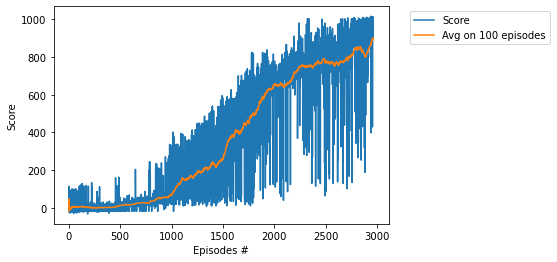

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [11]:
env.close()